## Import libraries

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as keras_image

## Define the file paths

In [2]:
train_file_path = "Train"
test_file_path = "Test"

## Load/resize the image from directory 

In [3]:
image_size = (180, 180)

In [4]:
train_set = tf.keras.utils.image_dataset_from_directory(
    train_file_path,
    image_size=image_size,
    batch_size=32,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training'
)

Found 47009 files belonging to 2 classes.
Using 37608 files for training.


In [5]:
test_set = tf.keras.utils.image_dataset_from_directory(
    test_file_path,
    image_size=image_size,
    batch_size=32,
    shuffle=False,
    validation_split=False
)

Found 11649 files belonging to 2 classes.


In [6]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    train_file_path,
    image_size=image_size,
    batch_size=32,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation'
)

Found 47009 files belonging to 2 classes.
Using 9401 files for validation.


## Display the image classes

In [7]:
img_class = train_set.class_names
img_class

['female', 'male']

## Apply rescaling to normalize pixel values

In [8]:
train_set = train_set.map(lambda x, y: (x/255.0, y))
test_set = test_set.map(lambda x, y: (x/255.0, y))
validation_set = validation_set.map(lambda x, y: (x/255.0, y))

## Visualize Image Classes

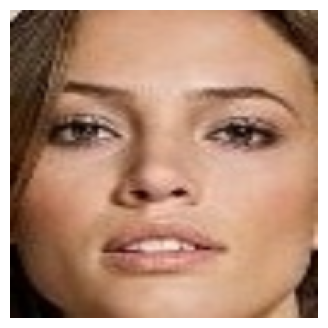

In [50]:
idx = 0 
plt.figure(figsize=(4,4))
for image, label in train_set.take(1):
    image = image[idx].numpy()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

## Setup the model using functional api

In [10]:
# Define the inputs
input_shape = (180, 180, 3)
input_layer = Input(shape=input_shape)

# Add the convolutional/pooling layers
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPool2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(128, (3,3), activation='relu')(x)
x = MaxPool2D((2,2))(x)

# Flatten the output of the convolutional layers
x = Flatten()(x)
x = Dropout(0.5)(x)

# Add output layer
output_layer = Dense(1, activation='sigmoid')(x)

## Define the model

In [11]:
model = Model(inputs=input_layer, outputs=output_layer)

## print the model summary

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856 

## Compile the model

In [13]:
loss = keras.losses.BinaryCrossentropy()
optim = keras.optimizers.Adam(learning_rate=0.001)
metric = ['accuracy']
model.compile(loss=loss, optimizer=optim, metrics=metric)

### Autotune the model for speed in training

In [14]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

## Fit the model for training

In [15]:
model.fit(train_set, validation_data=validation_set, batch_size=64, epochs=3)

Epoch 1/3
1176/1176 [==============================] - 2111s 2s/step - loss: 0.2790 - accuracy: 0.8856 - val_loss: 0.2081 - val_accuracy: 0.9226
Epoch 2/3
1176/1176 [==============================] - 1831s 2s/step - loss: 0.1929 - accuracy: 0.9288 - val_loss: 0.1803 - val_accuracy: 0.9339
Epoch 3/3
1176/1176 [==============================] - 1975s 2s/step - loss: 0.1673 - accuracy: 0.9376 - val_loss: 0.1667 - val_accuracy: 0.9382


### Evaluate the model

In [16]:
model.evaluate(test_set)

365/365 [==============================] - 110s 300ms/step - loss: 0.1308 - accuracy: 0.9502


[0.130839541554451, 0.9502103328704834]

## Predict the Model

In [54]:
predictions = model.predict(test_set)
predictions[0]

365/365 [==============================] - 77s 210ms/step


array([0.0023988], dtype=float32)

## Save the trained model

In [18]:
model.save('human_portrait.tf')

INFO:tensorflow:Assets written to: human_portrait.tf\assets


INFO:tensorflow:Assets written to: human_portrait.tf\assets


## Load the saved model

1/1 [==============================] - 0s 132ms/step


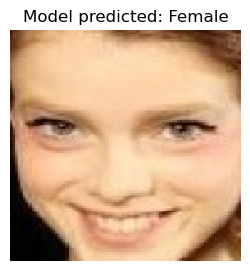

Prediction: [[0.00145864]]


In [53]:
# Use raw string literal (r'') to avoid escape character issues
img_path = r"Test\female\113002.jpg.jpg"
 
# Load the image from file
img = keras_image.load_img(img_path, target_size=(180, 180))
img_array = keras_image.img_to_array(img)

# Expand dimensions to create batch size of 1
img_array = np.expand_dims(img_array, axis=0)  

# Normalize the image data
img_array = img_array / 255.0 

# Load the saved model
model = keras.models.load_model('human_portrait.tf')

# Make prediction
prediction = model.predict(img_array)

# Interpret the prediction
predicted_class = "Male" if prediction[0][0] > 0.5 else "Female"

# Plot the image
plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.axis('off')
plt.title(f"Model predicted: {predicted_class}")
plt.show()

print(f"Prediction: {prediction}")

